In [ ]:
#!pip install -r requirements.txt

In [24]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostClassifier

sys.path.append('/home/adelev/Рабочий стол/McKinsey_hack/McKinsey_Severstal_Hack_2022') # Заменить на свой

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Структура

server2022 - основная папка, в которой храним файлы для предобработки данных, генерации признаков и пайплайн обучения модели. 

**prepare_data.py** - файл с фунциями предобработки данных

**train_val.py** - файл с пайплайном модели

**model_features.py** файл c функцими генерации признаков

In [33]:
from server2022.data.processed.prepare_data import create_df_0years_known, create_df_1year_known
from server2022.src.model_features import Feature_gen
from server2022.src.feature_importance_plot import plot_feature_importance
from server2022.src.train_val import *

# Постановка задачи 

1) Поскольку важно делать предсказания факта просрочки тем клиентам, которые сотрудничают с Северсталью давно, а также с новыми клиентами, **то принято решения построить 2 выборки и на них обучить 2 модели**: 

  1. **Уже работали с клиентом** и есть информация, какие просрочки были при работе с ним. Для этого используется функция **create_df_1year_known**, в которой есть колонки о данных по просроченным платежам клиентов

  2. **Клиент новый** и про него нет информации, как он оплачивает. Эту выборку делаем с помощью функции **create_df_0years_known**
  
2) **Правильно построить разделение выборки на тренировочную и тестовую, чтобы не было завышения метрик модели.** 

  1. Нельзя, чтобы данные по клиенту за один год были как в обучающей, так и в тестовой выборке,  
  2. Для 1ой задачи разбить клиенов по id, и чтобы какая-то часть id вообще не попадала в обучающаю выборку, а былоа только в тесте. 
 
3) **Отобрать признаки, которые дают наибольший прирост качеству моделей**

### 1) Модель для клиентов, с которыми уже работали

In [11]:
df_known_clients = create_df_1year_known()

В обучающую выборку попадут данные по клиентам за 2020 и 2019 год, а в тестовую за 2021 год. Поскольу в данных минимальный год 2016, в фичи обучающей выборки есть возможность добавить финансовые данные только на 4 года назад(в 2020 известны за 2016). Для сохранения целостности формирования обучающей и тестовой выборки, в тестовую выборку будем добавлять тоже только данные за предыдущие 4 года, т.е. с 2017 по 2021. 

In [9]:
feat_gen = Feature_gen(-4, -1)

### описание фичей
Первоначальные запуски модели на исходных данных показали, что **наибольшую роль играют финансовые признаки**. Поэтому в модель добавляли признаки, показывающие финансовое и экономическое развитие компании: 

    1. Разница между показателями за год. Чтобы описать как динамически менялось финансовое состоянии компании,  добавили последовательно разницу между всеми годами, до текущего в выборке 
    2. Аналогично относительное изменение, т.е. эти величины не исходных единицах измерения, а в относительных, показывающее во сколько раз тот или иной показатель вырос или упал относительно прошлого года. 
    3. Относительное изменение относительно выручки. Этот признак похож на тот, что в пункте 2, но измнение показателя считается не относительно себя самого, а относительно выручки.
    
Поскольку признаки стали иметь очень разный масштаю, для них была **применена нормировка MinMaxScaler()**

In [12]:
df_known_clients = feat_gen.preprocessing_before_fitting(df_known_clients)

**Для обучения и предсказания будем использовать модель catboost**

In [30]:
def catboost_fit_predict(df, comment=''):
    model = CatBoostClassifier(iterations=500,
                               depth=5, 
                               l2_leaf_reg=5, 
                               learning_rate=0.01433,
                               loss_function='Logloss',
                               use_best_model=False,
                               eval_metric='AUC',
                               verbose=False,
                               class_weights=[1, 0.0006],
                               random_seed=RANDOM_STATE,
                              )

    make_report(model, df, treshold=0.5, to_file=False);

    X_train, X_test, y_train, y_test = data_split(df)
    probas = model.predict_proba(X_test)[:, 1]

    best = 0
    xx = 0
    for x in sorted(probas):
        pr = precision_score(y_test, probas >= x)
        rl = recall_score(y_test, probas >= x)
        cur = f1_score(y_test, probas >= x)
        if cur >= best:
            best = cur
            xx = x

    make_report(model, df, treshold=xx, to_file=True, file_path='../reports/report_0_years.csv', comment=comment)
    
    return model

Fitting model <catboost.core.CatBoostClassifier object at 0x7f4fb51f7130> with treshold = 0.5...


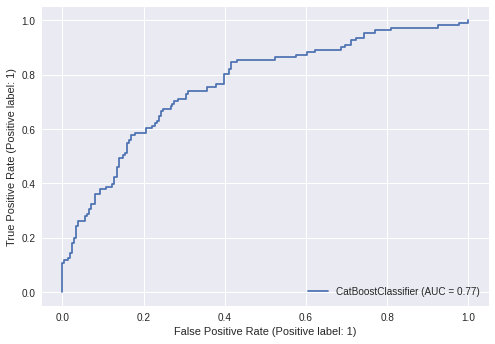

F1 = 0.0, Precision = 0.0, Recall = 0.0, Accuracy = 0.6585, ROC_AUC = 0.7655
Fitting model <catboost.core.CatBoostClassifier object at 0x7f4fb51f7130> with treshold = 0.0...


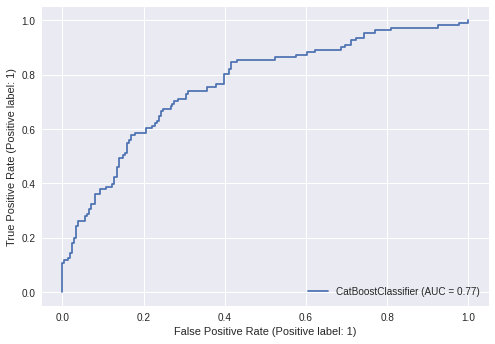

F1 = 0.6395, Precision = 0.5137, Recall = 0.8468, Accuracy = 0.6738, ROC_AUC = 0.7655


In [35]:
fitted_model_known = catboost_fit_predict(df_known_clients)

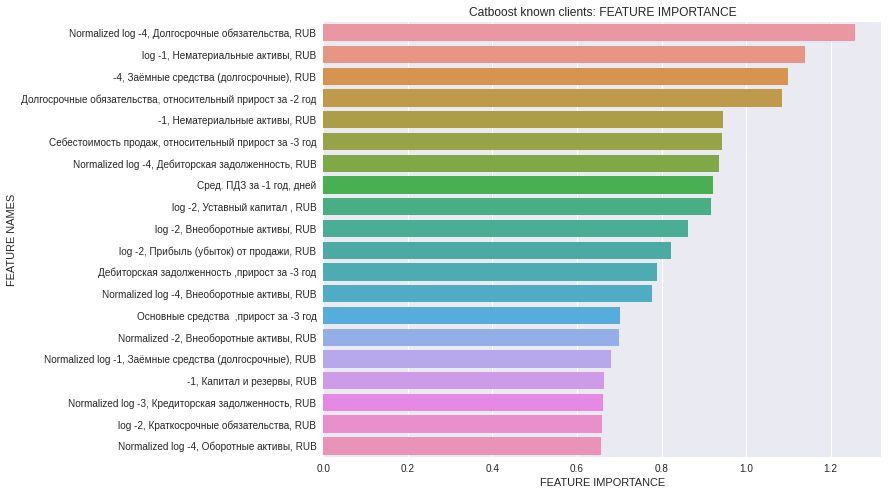

In [40]:
X_train, X_test, y_train, y_test = data_split(df_known_clients)
feature_importance = fitted_model_known.get_feature_importance()
column_name = X_train.columns

plot_feature_importance(feature_importance, column_name, "Catboost known clients: ")

# Вывод

# Модель для клиентов, с которыми раньше не работали 

Обучающая выборка - клиенты в 2019 и 2020 году, тестовая 2021 год. В данной постановке задачи не будем знать информацию по просрочкам клиентов, то есть даже если сотрудничали с клиентом в 2019 и 2020 году, **не будем добавлять в признаки информацию о просрочке платежа.**

In [16]:
df_unknown_clients = create_df_0years_known()

**Будут использоваться такие же фичи по финансовым показателям, как и в предыдущей модели.**

In [17]:
df_unknown_clients = feat_gen.preprocessing_before_fitting(df_unknown_clients)

Fitting model <catboost.core.CatBoostClassifier object at 0x7f4fb541ceb0> with treshold = 0.5...


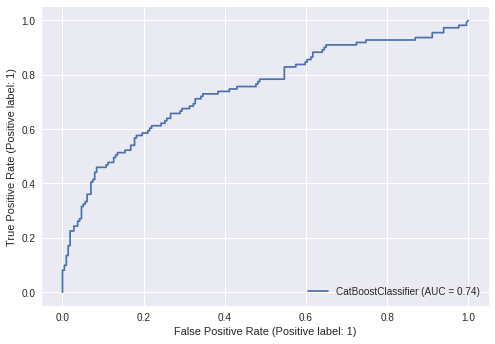

F1 = 0.0, Precision = 0.0, Recall = 0.0, Accuracy = 0.6585, ROC_AUC = 0.7447
Fitting model <catboost.core.CatBoostClassifier object at 0x7f4fb541ceb0> with treshold = 0.0...


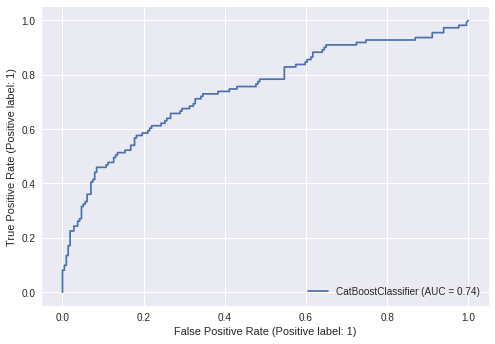

F1 = 0.609, Precision = 0.5226, Recall = 0.7297, Accuracy = 0.68, ROC_AUC = 0.7447


In [37]:
fitted_model_unknown = catboost_fit_predict(df_unknown_clients)

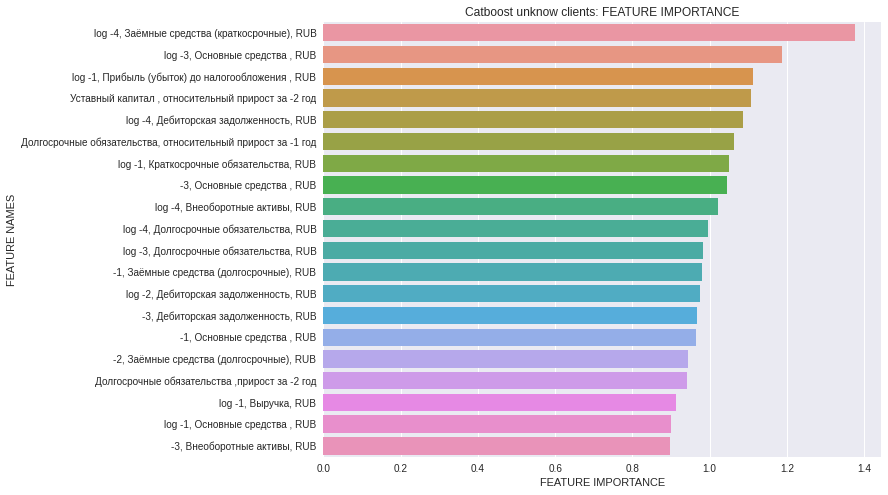

In [39]:
X_train, X_test, y_train, y_test = data_split(df_unknown_clients)
feature_importance = fitted_model_unknown.get_feature_importance()
column_name = X_train.columns

plot_feature_importance(feature_importance, column_name, "Catboost unknow clients: ")

# Вывод